# Clustering Customers based on Wholesale Spending with DBSCAN

## The Data


Source: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

Margarida G. M. S. Cardoso, margarida.cardoso '@' iscte.pt, ISCTE-IUL, Lisbon, Portugal


Data Set Information:

Provide all relevant information about your data set.


Attribute Information:

    1) FRESH: annual spending (m.u.) on fresh products (Continuous);
    2) MILK: annual spending (m.u.) on milk products (Continuous);
    3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
    4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
    5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
    6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
    7) CHANNEL: customers  Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
    8) REGION: customers  Region Lisnon, Oporto or Other (Nominal)
 

Relevant Papers:

Cardoso, Margarida G.M.S. (2013). Logical discriminant models â€“ Chapter 8 in Quantitative Modeling in Marketing and Management Edited by Luiz Moutinho and Kun-Huang Huarng. World Scientific. p. 223-253. ISBN 978-9814407717

Jean-Patrick Baudry, Margarida Cardoso, Gilles Celeux, Maria JosÃ© Amorim, Ana Sousa Ferreira (2012). Enhancing the selection of a model-based clustering with external qualitative variables. RESEARCH REPORT NÂ° 8124, October 2012, Project-Team SELECT. INRIA Saclay - ÃŽle-de-France, Projet select, UniversitÃ© Paris-Sud 11



-----

## DBSCAN and Clustering Examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../DATA/wholesome_customers_data.csv')

In [3]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


## EDA

Creating a scatterplot showing the relation between MILK and GROCERY spending, colored by Channel column

In [5]:
df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

<Axes: xlabel='Milk', ylabel='Grocery'>

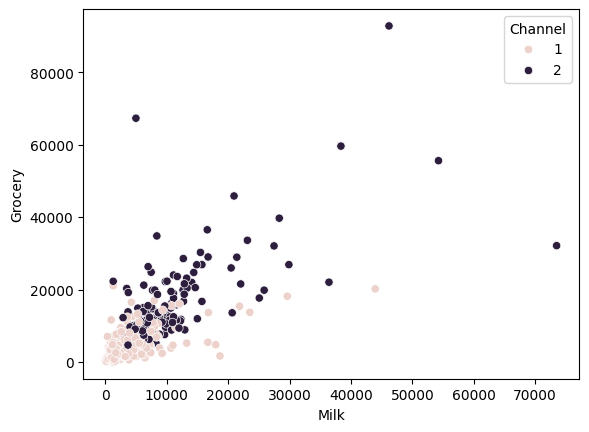

In [6]:
sns.scatterplot(df, x='Milk', y='Grocery', hue='Channel')

Creating a histogram of MILK spending, colored by Channel

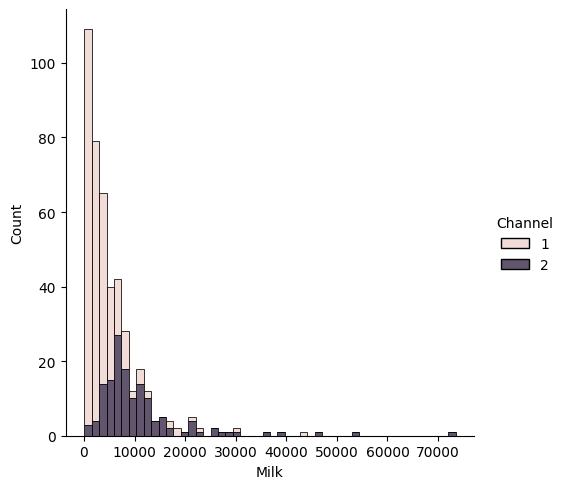

In [7]:
sns.displot(df, x='Milk', hue='Channel', multiple='stack');

Creating an annotated clustermap of the correlations between spending on different categories

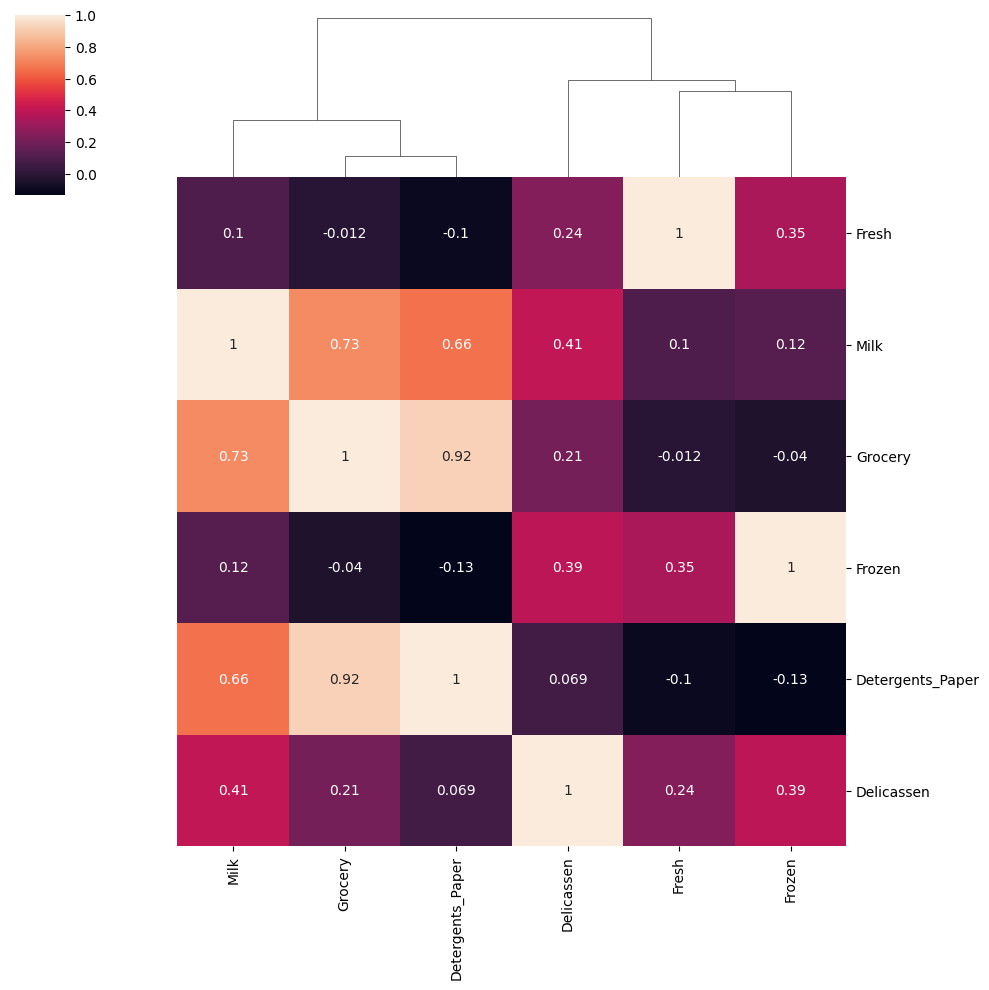

In [8]:
sns.clustermap(df.drop(['Region', 'Channel'], axis=1).corr(), annot=True, row_cluster=False);

Creating a PairPlot of the dataframe, colored by Region

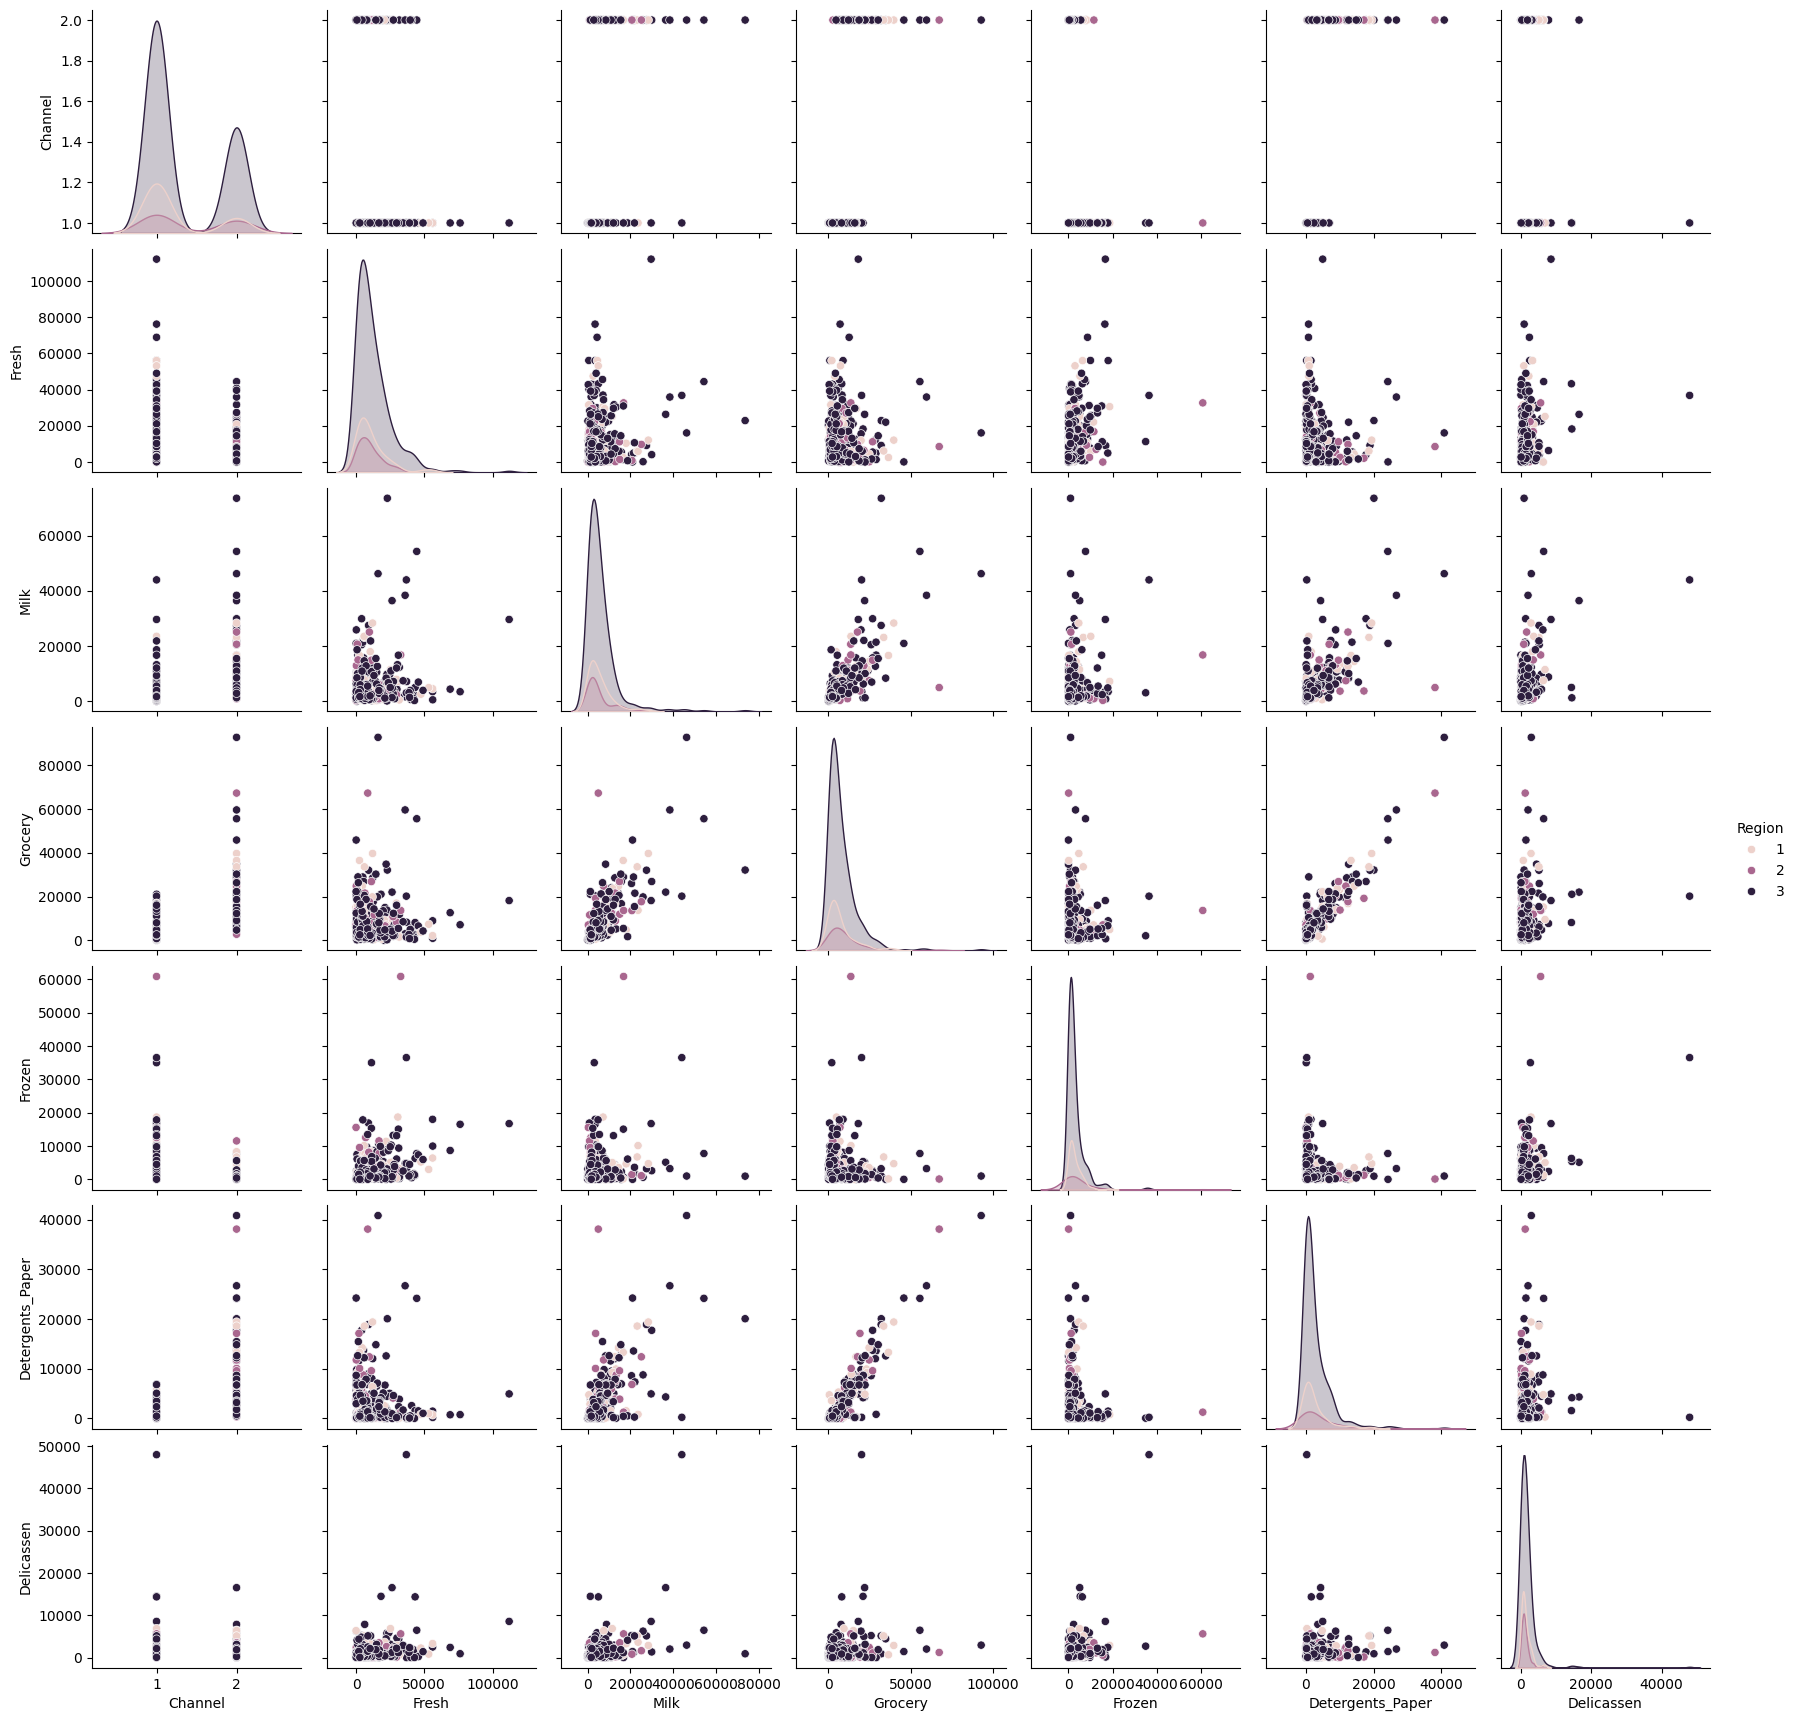

In [9]:
sns.pairplot(df, hue='Region');

Looking at the region, there are no major differences between categories

## DBSCAN

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()

In [12]:
scaled_df = scaler.fit_transform(df)

Using DBSCAN and a for loop to create a variety of models testing different epsilon values

In [13]:
from sklearn.cluster import DBSCAN

In [14]:
n = 50
outlier_percent = np.zeros(n)
eps_seq = np.linspace(0.001, 3, n)
n_features = scaled_df.shape[1]

i = 0
for eps in eps_seq:
    dbscan = DBSCAN(eps=eps, min_samples=2*n_features)
    dbscan.fit(scaled_df)

    outlier_percent[i] = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_ )
    i += 1

Creating a line plot of the percentage of outlier points versus the epsilon value

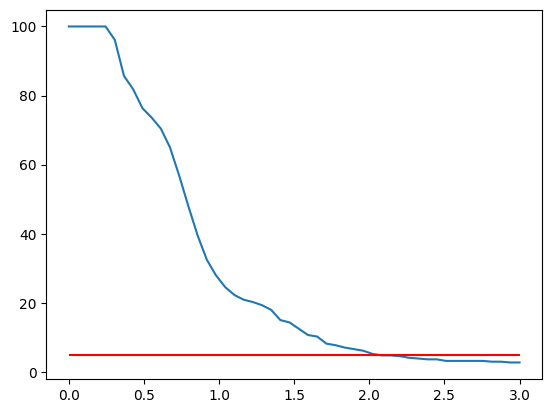

In [15]:
plt.plot(eps_seq, outlier_percent)
plt.hlines(y=5, xmin=0, xmax=3, color='r');

## DBSCAN with Chosen Epsilon

Retraining a DBSCAN model with eps=2

In [16]:
final_model = DBSCAN(eps=2, min_samples=2*n_features)

In [17]:
cluster_labels = final_model.fit_predict(scaled_df)

Creating a scatterplot of Milk vs Grocery, colored by the discovered labels of the DBSCAN model

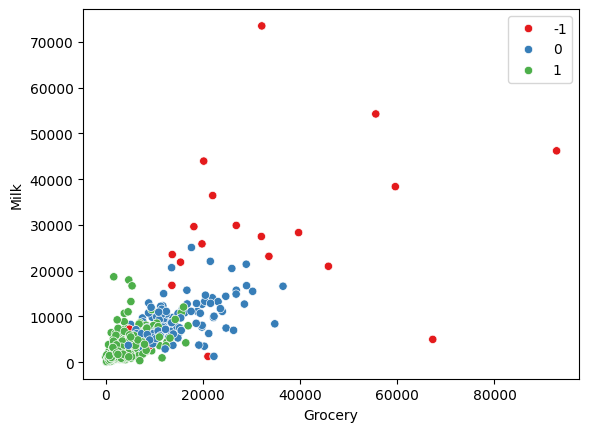

In [18]:
sns.scatterplot(df, y='Milk', x='Grocery', hue=cluster_labels, palette='Set1');

Creating a scatterplot of Milk vs. Detergents Paper colored by the labels

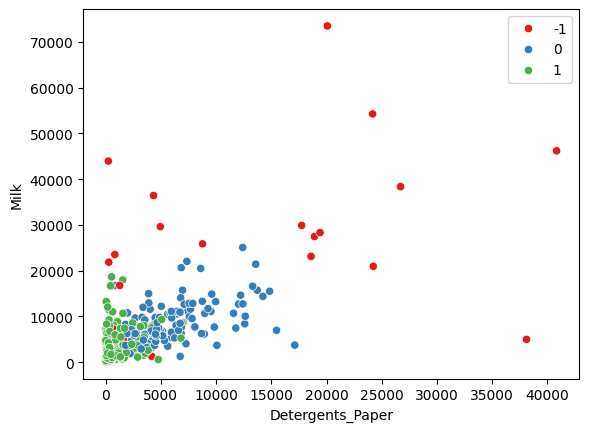

In [19]:
sns.scatterplot(df, y='Milk', x='Detergents_Paper', hue=cluster_labels, palette='Set1');

Creating a new column on the original dataframe called "Labels" consisting of the DBSCAN labels

In [20]:
df['Labels'] = cluster_labels

In [21]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,0


Comparing the statistical mean of the clusters and outliers for the spending amounts on the categories

In [22]:
mean_spent = df.drop(['Channel', 'Region'], axis=1).groupby('Labels').mean()

In [23]:
mean_spent

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,
-1,27729.920000,22966.960000,26609.600000,11289.640000,11173.560000,6707.160000
0,8227.666667,8615.852713,13859.674419,1447.759690,5969.581395,1498.457364
1,12326.972028,3023.559441,3655.328671,3086.181818,763.783217,1083.786713


Outliers found spend much more on the above categories

Normalizing the dataframe using MinMaxScaler so the spending means go from 0-1 and creating a heatmap of the values

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
MMscaler = MinMaxScaler()

In [26]:
scaled_mean_spent = MMscaler.fit_transform(mean_spent)

In [27]:
scaled_mean_spent = pd.DataFrame(scaled_mean_spent, columns=mean_spent.columns, index=np.unique(cluster_labels))

In [28]:
scaled_mean_spent

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,0.000000,0.280408,0.444551,0.000000,0.500087,0.073741
1,0.210196,0.000000,0.000000,0.166475,0.000000,0.000000


<Axes: >

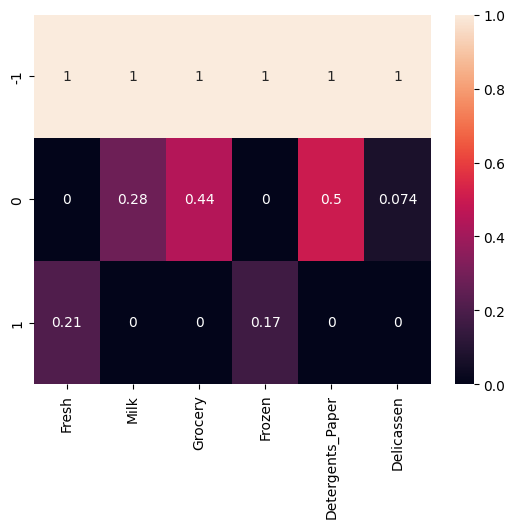

In [29]:
sns.heatmap(scaled_mean_spent, annot=True)

Creating another heatmap similar to the one above, but with the outliers removed

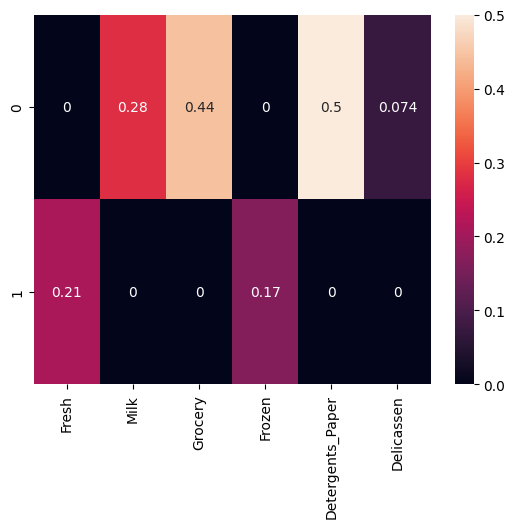

In [30]:
sns.heatmap(scaled_mean_spent.drop(-1), annot=True);

They differ the most for the Detergents_Paper and Grocery categories